<a href="https://colab.research.google.com/github/Group2-P6-Bachelor-Project/Model/blob/main/P6_Bachelor_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting and Importing packages

In [ ]:
!pip install pyunpack
!pip install patool
!pip uninstall tensorflow
!pip install tf-nightly
import tensorflow as tf
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.14.0-dev20230503


In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
from pyunpack import Archive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mkdir my_dataset
Archive('/content/gdrive/MyDrive/InitialV2.rar').extractall('/content/my_dataset')

mkdir: cannot create directory ‘my_dataset’: File exists


In [ ]:
import tensorflow as tf
import pathlib

data_dir = pathlib.Path('/content/my_dataset/InitialV2')

In [ ]:
img_size = (260, 260)
batch_size = 32
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset= 'both',
    seed=0,
    image_size=img_size,
    batch_size=batch_size)

Found 2945 files belonging to 6 classes.
Using 2356 files for training.
Using 589 files for validation.



# Attempt #2

In [ ]:
img_size = (260, 260)
batch_size = 32
train_accs = []
val_accs = []
seeds = [1234551]
for seed in seeds:
  train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset= 'both',
      seed=seed,
      image_size=img_size,
      batch_size=batch_size)

  data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
      tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ])

  train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
  label_names = sorted(item.name for item in data_dir.glob('*/') if item.is_dir())
  label_encoder = tf.keras.layers.experimental.preprocessing.StringLookup()
  label_encoder.adapt(label_names)

  # Map the labels to integers
  train_labels = train_ds.map(lambda x, y: label_encoder(y))
  val_labels = val_ds.map(lambda x, y: label_encoder(y))

  num_classes = len(label_encoder.get_vocabulary())

  base_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet', input_shape=(260, 260, 3))
  base_model.trainable = False
  inputs = tf.keras.Input(shape=(260, 260, 3))
  x = base_model(inputs, training=False)
  #Andres said it should be removed but removing it breaks the code
  x = tf.keras.layers.GlobalAveragePooling2D()(x)\
  #Add more layers her

  outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)

  #show model.summary

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  history = model.fit(train_ds,
                      validation_data=val_ds,
                      epochs=20)
  train_accs.append(history.history['accuracy'][-1])
  val_accs.append(history.history['val_accuracy'][-1])

for i in range(len(seeds)):
    print(f'Seed {seeds[i]}: Train accuracy = {train_accs[i]}, Validation accuracy = {val_accs[i]}')

Found 2945 files belonging to 6 classes.
Using 2356 files for training.
Using 589 files for validation.


Epoch 1/20
74/74 [==============================] - 73s 761ms/step - loss: 0.9642 - accuracy: 0.6974 - val_loss: 0.5261 - val_accuracy: 0.8540
Epoch 2/20
74/74 [==============================] - 58s 750ms/step - loss: 0.4757 - accuracy: 0.8548 - val_loss: 0.3995 - val_accuracy: 0.8846
Epoch 3/20
74/74 [==============================] - 56s 718ms/step - loss: 0.3826 - accuracy: 0.8803 - val_loss: 0.3478 - val_accuracy: 0.8947
Epoch 4/20
74/74 [==============================] - 54s 707ms/step - loss: 0.3278 - accuracy: 0.8973 - val_loss: 0.3231 - val_accuracy: 0.9083
Epoch 5/20
74/74 [==============================] - 61s 809ms/step - loss: 0.2891 - accuracy: 0.9096 - val_loss: 0.3057 - val_accuracy: 0.9049
Epoch 6/20
74/74 [==============================] - 57s 738ms/step - loss: 0.2638 - accuracy: 0.9177 - val_loss: 0.2892 - val_accuracy: 0.9117
Epoch 7/20
74/74 [==============================] - 55s 715ms/step - loss: 0.2479 - accuracy: 0.9198 - val_loss: 0.2764 - val_accuracy: 0.9151

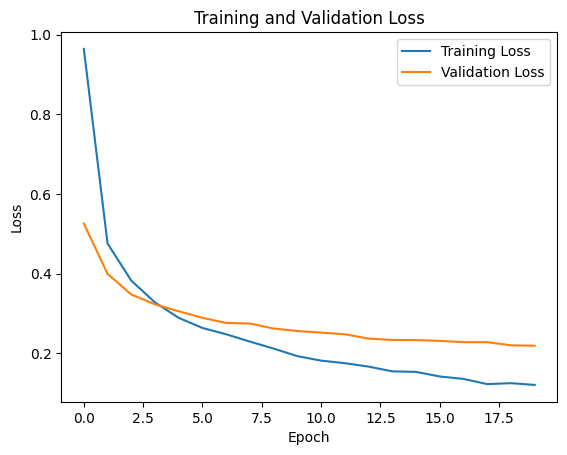

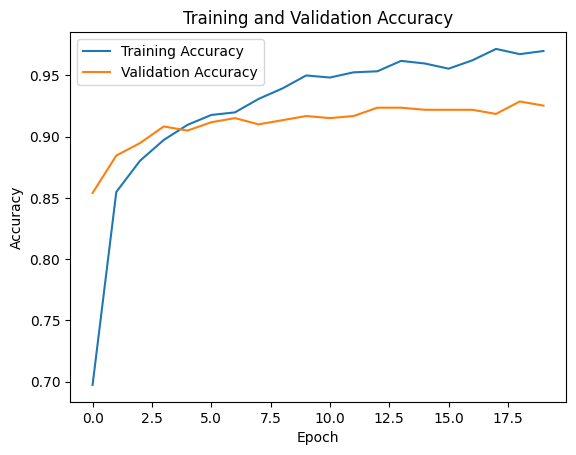

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Show the legend
plt.legend()

# Display the plot
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()

19/19 [==============================] - 7s 241ms/step


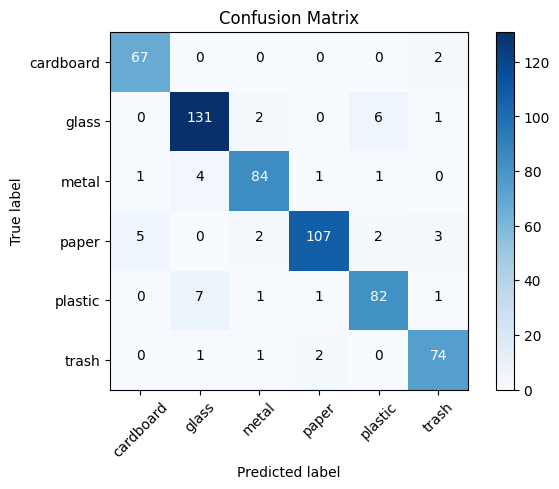

In [ ]:
#Confusion Matrix
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools

# Get the true labels and predicted labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(val_ds.class_names))
plt.xticks(tick_marks, val_ds.class_names, rotation=45)
plt.yticks(tick_marks, val_ds.class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

1/1 [==============================] - 2s 2s/step


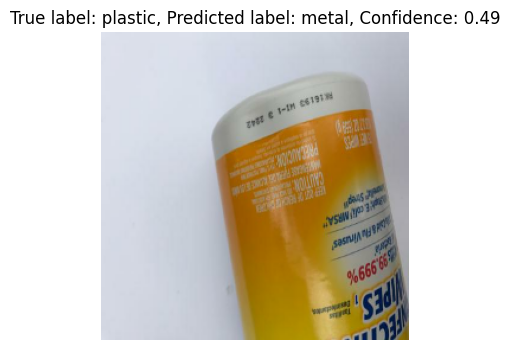

1/1 [==============================] - 0s 33ms/step


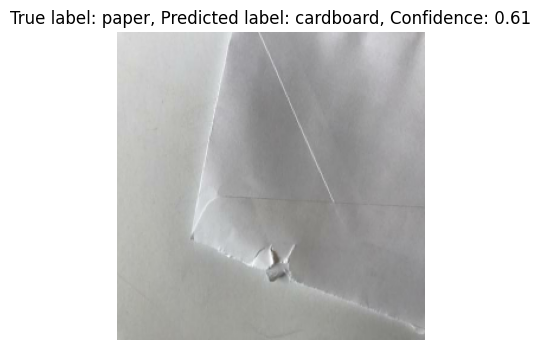

1/1 [==============================] - 0s 40ms/step


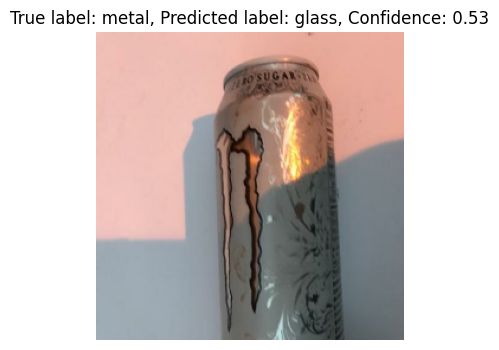

1/1 [==============================] - 0s 57ms/step


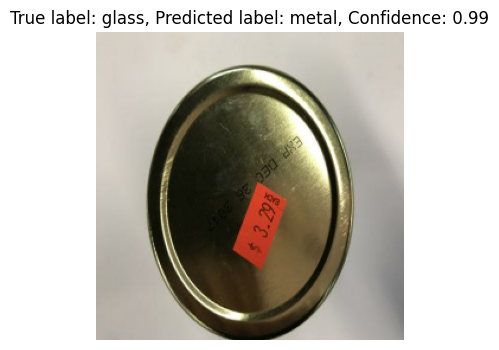

1/1 [==============================] - 0s 32ms/step


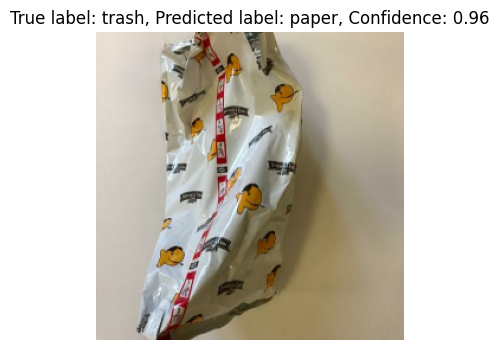

1/1 [==============================] - 0s 30ms/step


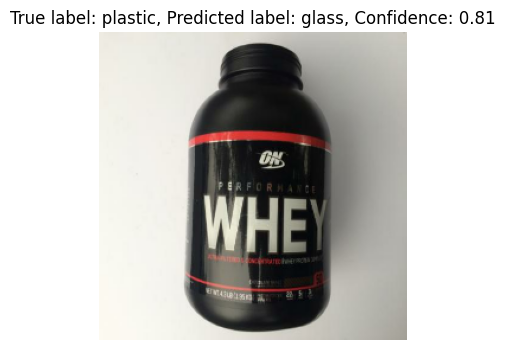

1/1 [==============================] - 0s 28ms/step


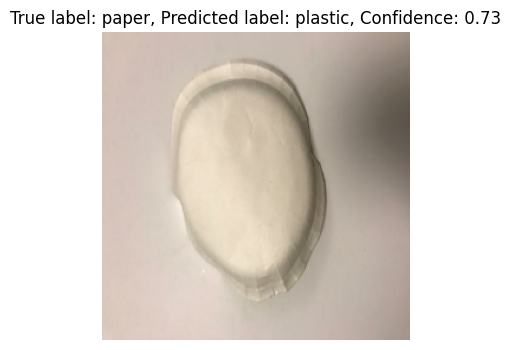

1/1 [==============================] - 0s 55ms/step


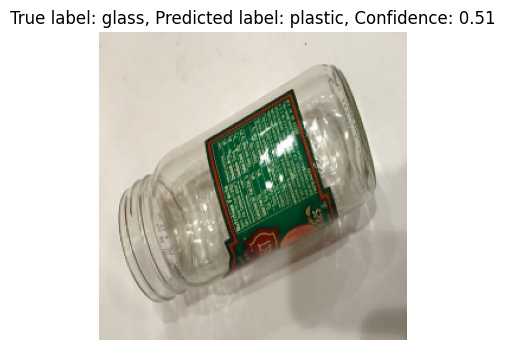

1/1 [==============================] - 0s 44ms/step


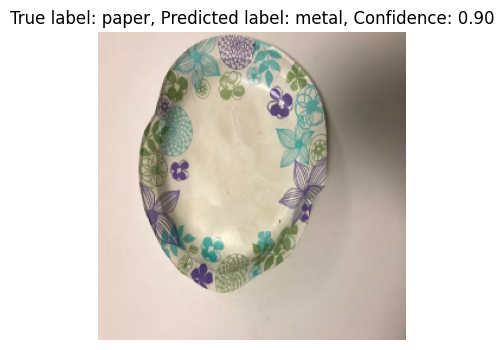

1/1 [==============================] - 0s 41ms/step


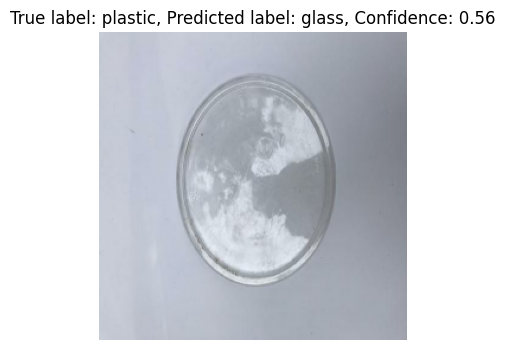

1/1 [==============================] - 0s 81ms/step


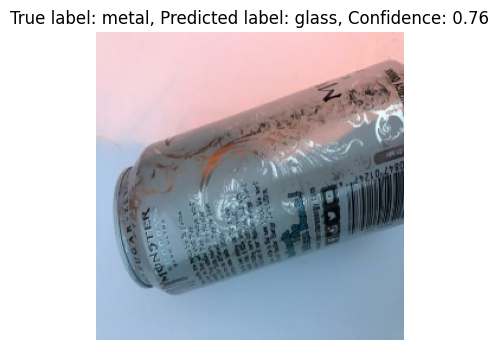

1/1 [==============================] - 0s 82ms/step


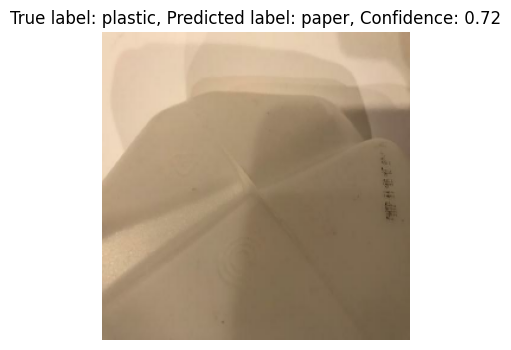

1/1 [==============================] - 0s 47ms/step


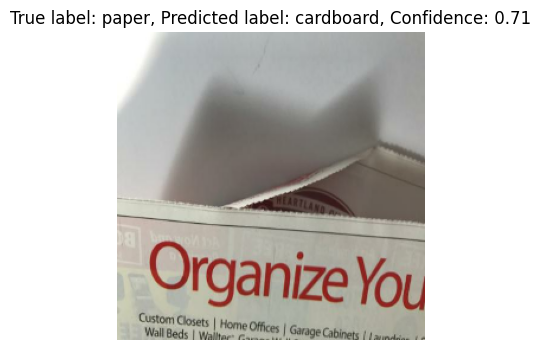

1/1 [==============================] - 0s 42ms/step


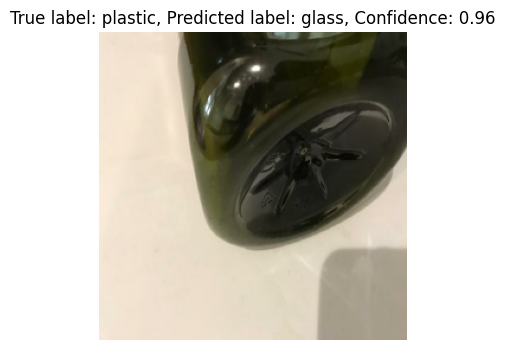

1/1 [==============================] - 0s 77ms/step


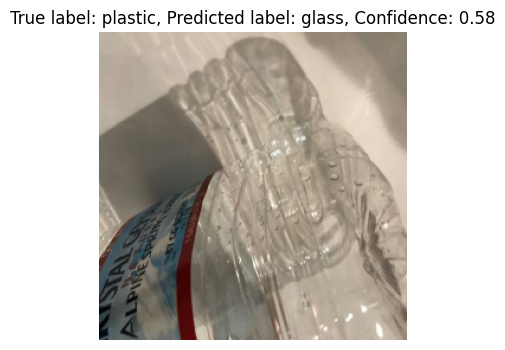

1/1 [==============================] - 0s 66ms/step


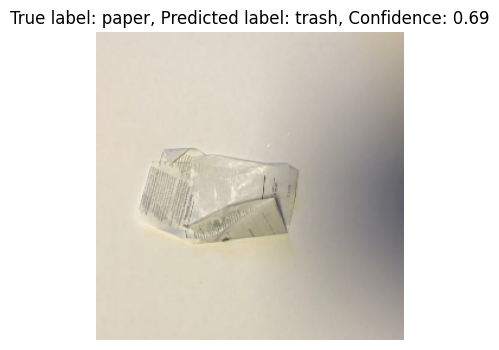

1/1 [==============================] - 0s 93ms/step


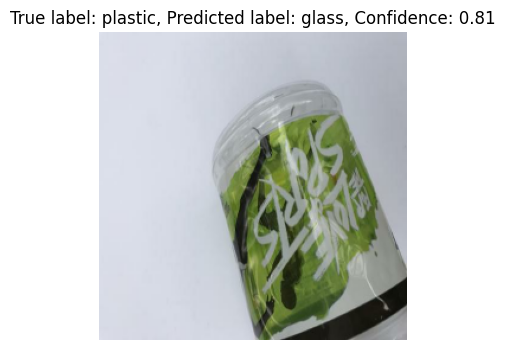

1/1 [==============================] - 0s 105ms/step


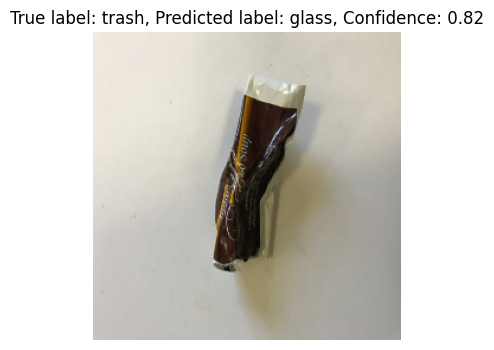

1/1 [==============================] - 0s 44ms/step


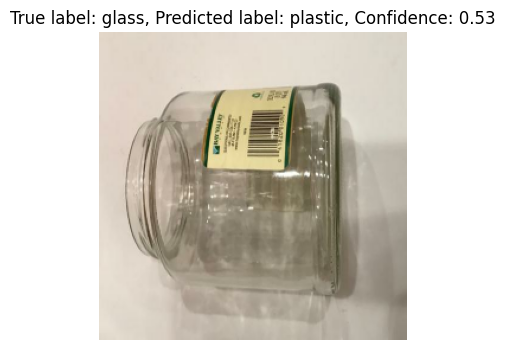

1/1 [==============================] - 0s 47ms/step


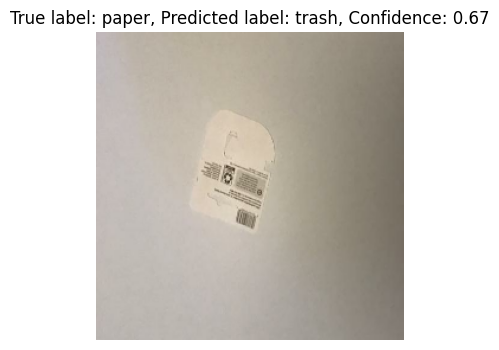

1/1 [==============================] - 0s 90ms/step


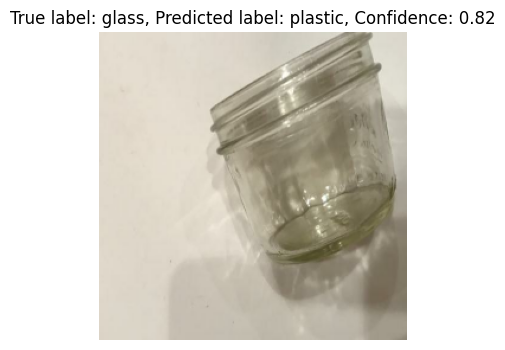

1/1 [==============================] - 0s 110ms/step


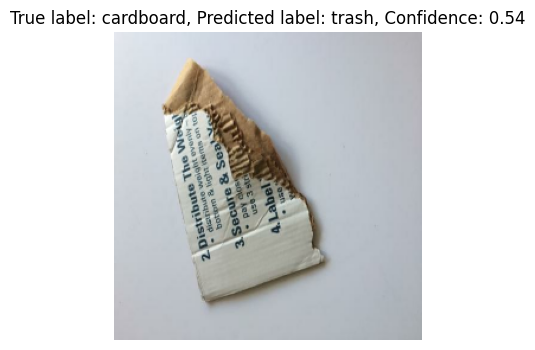

1/1 [==============================] - 0s 46ms/step


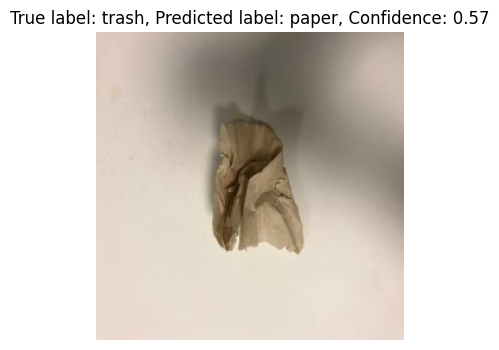

1/1 [==============================] - 0s 51ms/step


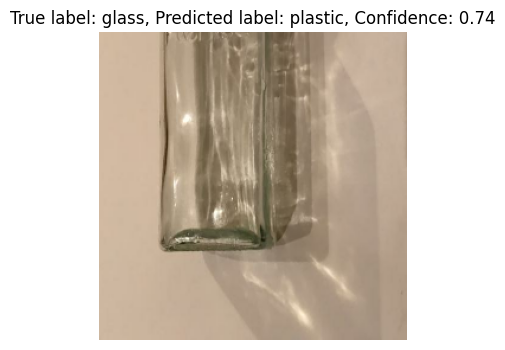

1/1 [==============================] - 0s 43ms/step


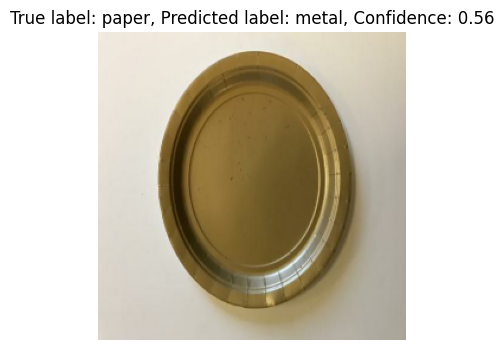

1/1 [==============================] - 0s 47ms/step


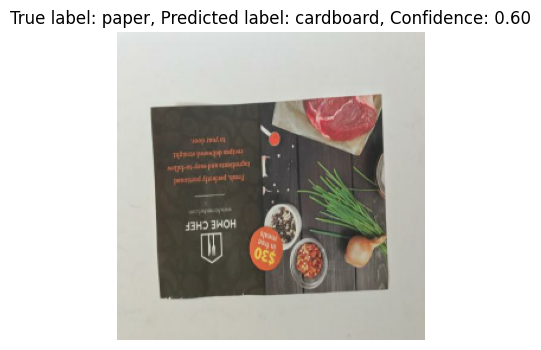

1/1 [==============================] - 0s 37ms/step


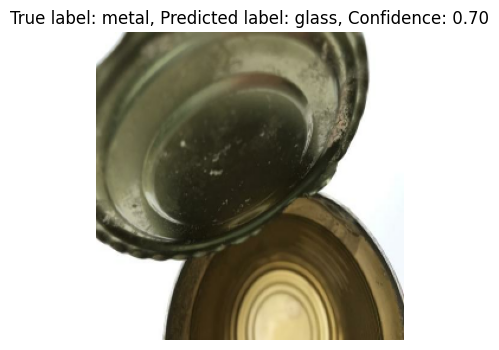

1/1 [==============================] - 0s 34ms/step


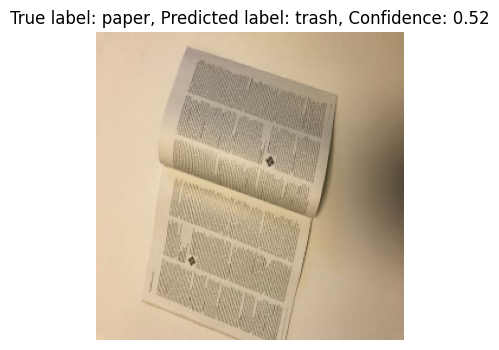

1/1 [==============================] - 0s 56ms/step


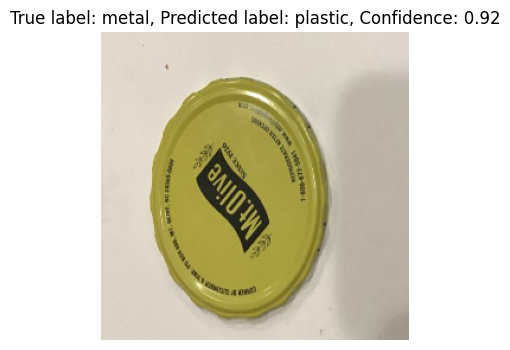

1/1 [==============================] - 0s 39ms/step


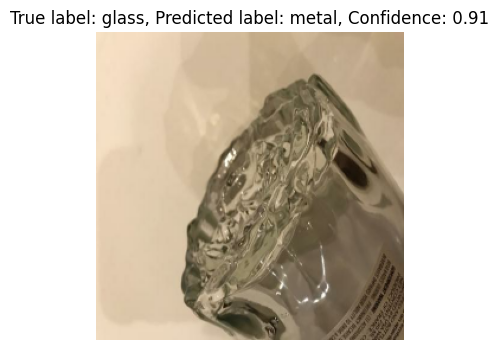

1/1 [==============================] - 0s 29ms/step


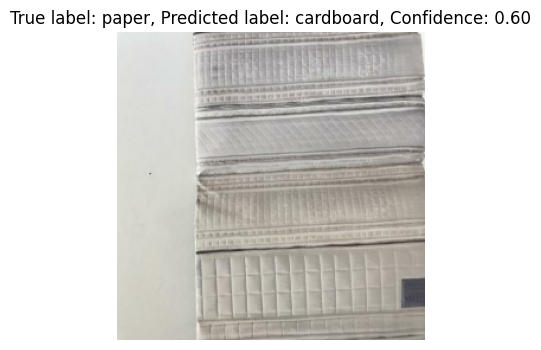

1/1 [==============================] - 0s 57ms/step


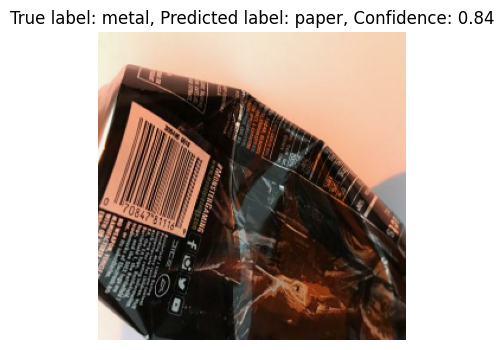

1/1 [==============================] - 0s 42ms/step


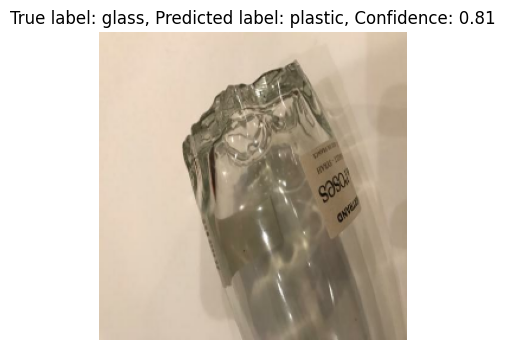

1/1 [==============================] - 0s 35ms/step


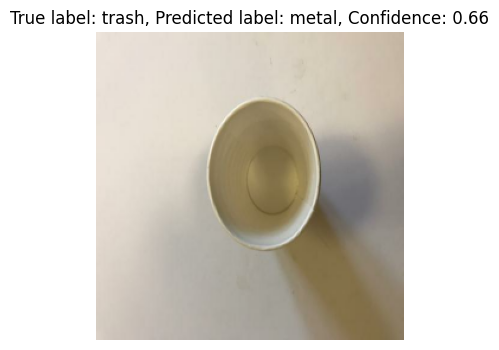

1/1 [==============================] - 0s 45ms/step


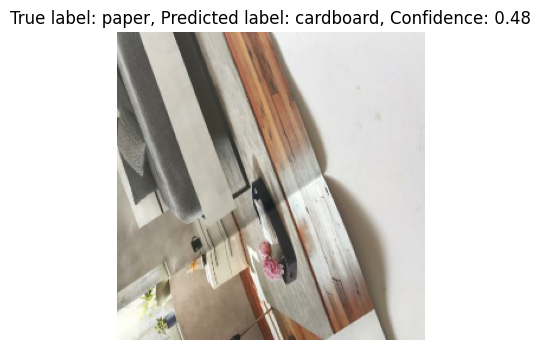

1/1 [==============================] - 0s 82ms/step


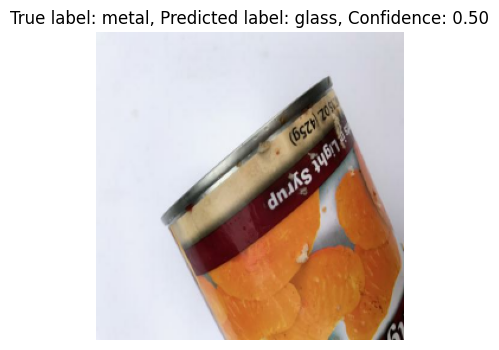

1/1 [==============================] - 0s 36ms/step


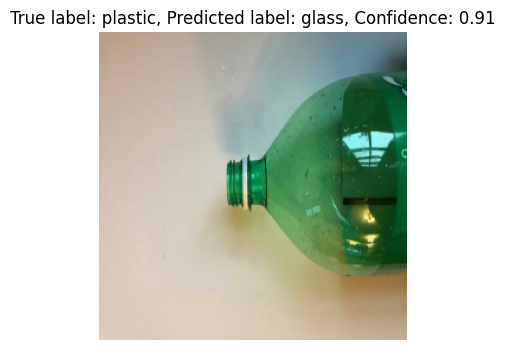

1/1 [==============================] - 0s 34ms/step


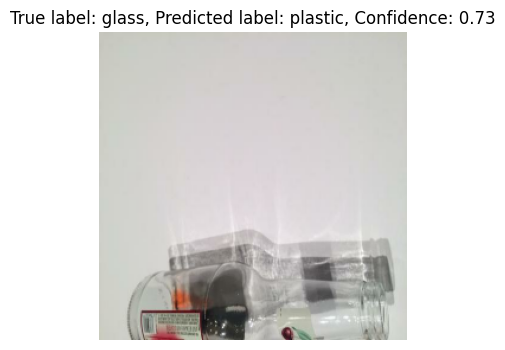

1/1 [==============================] - 0s 51ms/step


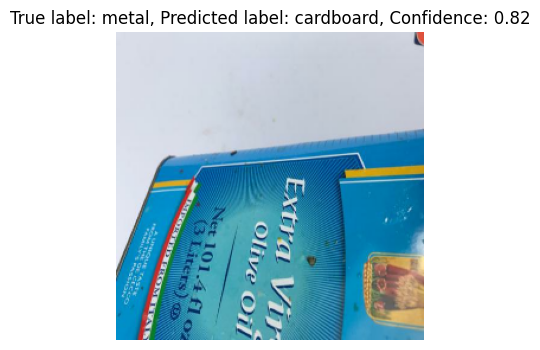

1/1 [==============================] - 0s 61ms/step


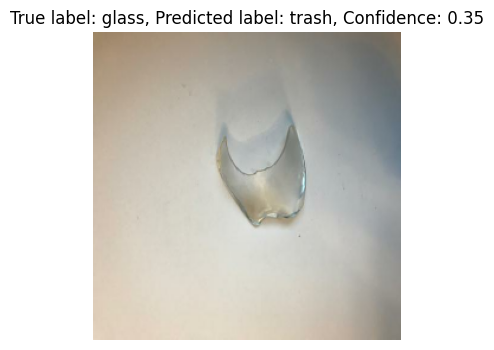

1/1 [==============================] - 0s 37ms/step


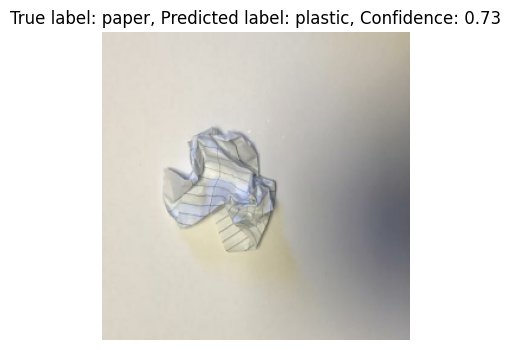

1/1 [==============================] - 0s 29ms/step


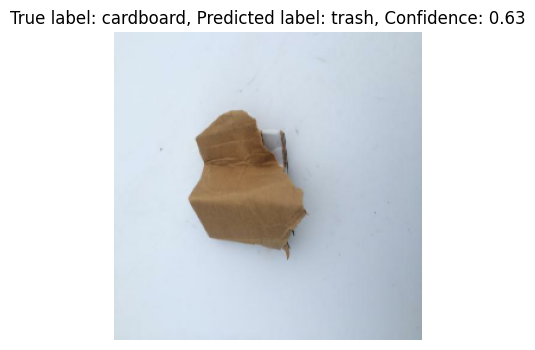

1/1 [==============================] - 0s 31ms/step


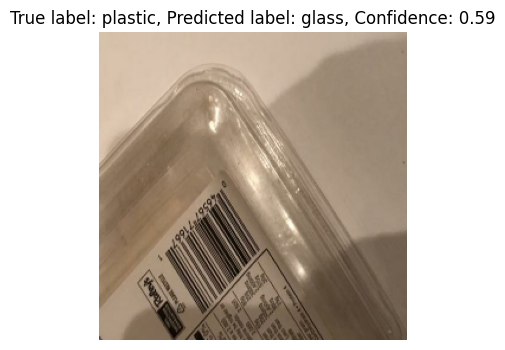

1/1 [==============================] - 0s 38ms/step


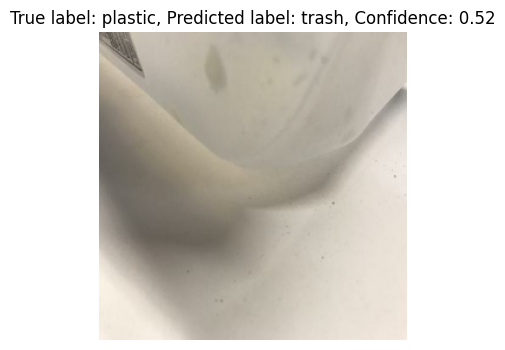

In [ ]:
def plot_misclassified_images(val_test_ds, y_true, y_pred, model):
    for i, (image, label) in enumerate(val_test_ds.unbatch()):
        if y_true[i] != y_pred[i]:
            # Get the predicted class probabilities
            probs = model.predict(np.expand_dims(image, axis=0))[0]
            pred_class_prob = probs[y_pred[i]]
            
            # Plot the image and mislabeled class information
            plt.figure(figsize=(4,4))
            plt.imshow(image.numpy().astype(np.uint8))
            plt.title(f'True label: {val_test_ds.class_names[y_true[i]]}, Predicted label: {val_test_ds.class_names[y_pred[i]]}, Confidence: {pred_class_prob:.2f}')
            plt.axis('off')
            plt.show()
plot_misclassified_images(val_ds, y_true, y_pred, model)

In [ ]:
new_model = tf.keras.models.load_model('100_epoch.h5')

19/19 [==============================] - 8s 254ms/step


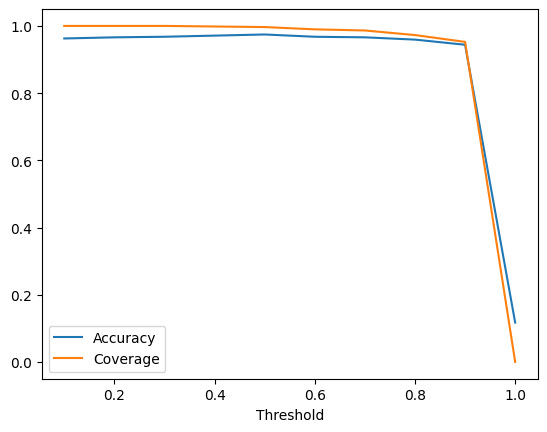

In [ ]:
def plot_misclassified_images(val_ds, model):
  # Get the predicted probabilities of the classes for the validation dataset
  y_prob = model.predict(val_ds)

  # Set different threshold values
  thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

  # Compute the accuracy and coverage for each threshold value
  accuracies = []
  coverages = []
  for threshold in thresholds:
      y_pred = np.argmax(y_prob > threshold, axis=-1)
      y_true = np.concatenate([y for x, y in val_ds], axis=0)
      accuracy = np.mean(y_pred == y_true)
      coverage = np.mean(np.max(y_prob, axis=-1) > threshold)
      accuracies.append(accuracy)
      coverages.append(coverage)

  # Plot the accuracy and coverage vs threshold curve
  plt.plot(thresholds, accuracies, label='Accuracy')
  plt.plot(thresholds, coverages, label='Coverage')
  plt.xlabel('Threshold')
  plt.legend()
  plt.show()
plot_misclassified_images(val_ds, new_model)

In [ ]:
#Fine-Tuning add custom layers that fit our problem
#Freeze the base layers of the model and train only the custom layers that we added
#Unfreeze the top layers of the model and retrain them together with the custom layers
#Compare the results you are getting and modify the layers to get better results

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# # Get a batch of images and labels
# images, labels = next(iter(val_ds))
# image = tf.keras.preprocessing.image.load_img('/content/IMG_0947.jpg', target_size=(260, 260))

# image_array = tf.keras.preprocessing.image.img_to_array(image)
# image_array = tf.keras.applications.efficientnet.preprocess_input(image_array)
# image_tensor = tf.convert_to_tensor(image_array)
# image_tensor = tf.expand_dims(image_tensor, axis=0)
# # Make predictions on the batch of images
# predictions = model.predict(image_tensor)

# # Get the predicted classes
# predicted_class = np.argmax(predictions, axis=1)[0]
# predicted_probability = predictions[0][predicted_class]
# # Get the true classes
# class_names_copy = label_names.copy()
# predicted_name = class_names_copy.pop(predicted_class)

# # Get the accuracy
# other_probabilities = [predictions[0][i] for i in range(len(class_names_copy))]

# other_sum = sum(other_probabilities)

# # Normalize the probabilities of the other classes
# other_probabilities = [p / other_sum * (1 - predicted_probability) for p in other_probabilities]

# # Display the image and the predicted class
# img = images[0]
# class_names = sorted(os.listdir(data_dir))

# plt.imshow(image)
# plt.title(f'Predicted: {class_names[predicted_class]}, Accuracy: {predicted_probability:.2f}')
# plt.show()
# # Display the other classes and their probabilities
# for i in range(len(class_names_copy)):
#     print(f'{class_names_copy[i]}: {other_probabilities[i]:.2f}')

In [ ]:
model.save("model5.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/regularizers.py:424: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'NoneType'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/constraints.py:363: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'NoneType'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
# !zip -r /content/hundred_epoch_model.zip /content/model
# from google.colab import files
# files.download('/content/hundred_epoch_model.zip')

In [ ]:
# import tensorflow as tf

# tflite_output_path = '/content/converted_model.tflite'

# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
# tflite_model = converter.convert()

# with open(tflite_output_path, 'wb') as f:
#     f.write(tflite_model)

Testing tflite model

In [ ]:
# interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
# interpreter.allocate_tensors()

# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

In [ ]:
# import numpy as np
# from PIL import Image

# # Define the data augmentation pipeline
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#   tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
# ])
# image = tf.keras.preprocessing.image.load_img('/content/IMG_0947.jpg', target_size=(260, 260))

# # Apply the data augmentation to the input image
# # image = data_augmentation(np.array(image))


# image = np.array(image, dtype=np.float32)


# image = tf.keras.applications.efficientnet.preprocess_input(image)
# image = np.expand_dims(image, 0)

In [ ]:
# interpreter.set_tensor(input_details[0]['index'], image)
# interpreter.invoke()
# output_data = interpreter.get_tensor(output_details[0]['index'])
# predicted_labels = np.argmax(output_data, axis=1)[0]

In [ ]:
# # Display the image and the predicted labels
# plt.imshow(image[0])
# plt.title("Predicted label: {}".format(class_names[predicted_labels]))
# plt.show()

# # Print the predicted probabilities for all labels
# for i in range(len(class_names)):
#     print("{}: {:.2f}%".format(class_names[i], output_data[0][i] * 100))

In [ ]:
# print(image[0].shape)

Validation with different datasets

In [ ]:
!mkdir my_validationset2

mkdir: cannot create directory ‘my_validationset2’: File exists


In [ ]:
from pyunpack import Archive
Archive('/content/gdrive/MyDrive/Validation_WastePicture.zip').extractall('/content/my_validationset2')

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
val_dir = pathlib.Path('/content/my_validationset2/Validation_WastePicture')
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      val_dir,
      image_size=img_size,
      validation_split=0,
      batch_size=batch_size,
      shuffle=False)

Found 1019 files belonging to 6 classes.


32/32 [==============================] - 4s 128ms/step


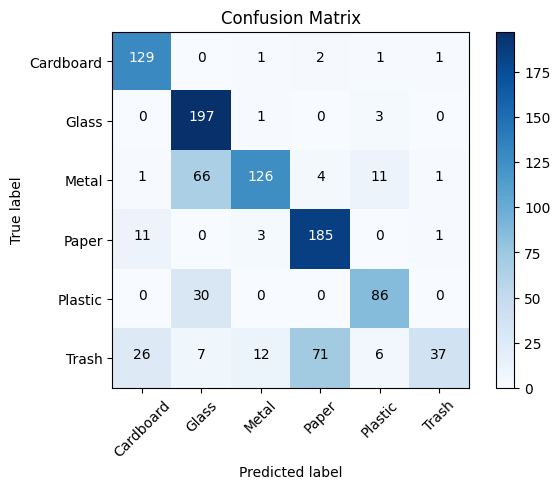

In [ ]:
#Confusion Matrix
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools

# Get the true labels and predicted labels
y_test_true = np.concatenate([y for x, y in val_test_ds], axis=0)
y_test_pred = np.argmax(model.predict(val_test_ds), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(val_test_ds.class_names))
plt.xticks(tick_marks, val_test_ds.class_names, rotation=45)
plt.yticks(tick_marks, val_test_ds.class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

32/32 [==============================] - 5s 143ms/step


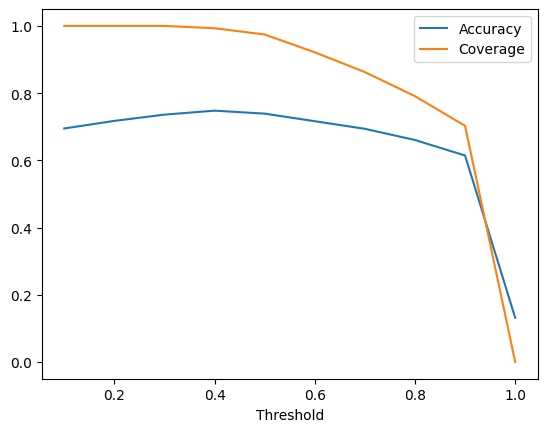

In [ ]:
plot_misclassified_images(val_test_ds, new_model)

In [ ]:
# plot_misclassified_images(val_test_ds, y_test_true, y_test_pred)

Testning 100 Epoch model with a confusion matrix

In [ ]:
# #Confusion Matrix
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import confusion_matrix
# import itertools

# # Get the true labels and predicted labels
# y_test_true = np.concatenate([y for x, y in val_test_ds], axis=0)
# y_test_pred = np.argmax(loaded_model.predict(val_test_ds), axis=-1)

# # Compute the confusion matrix
# cm = confusion_matrix(y_test_true, y_test_pred)

# # Plot the confusion matrix
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = np.arange(len(val_test_ds.class_names))
# plt.xticks(tick_marks, val_test_ds.class_names, rotation=45)
# plt.yticks(tick_marks, val_test_ds.class_names)

# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], 'd'),
#              horizontalalignment="center",
#              color="white" if cm[i, j] > thresh else "black")

# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

Ensembling

In [ ]:
# model1 = tf.keras.models.load_model('model2.h5')
# model2 = tf.keras.models.load_model('model4.h5')
# model3 = tf.keras.models.load_model('model5.h5')

In [ ]:
# model1._name = 'epoch30model'
# model2._name = 'epoch10model'
# model3._name = 'epoch100model'
# models = [model1, model2, model3]
# model_input = tf.keras.Input(shape=(260, 260, 3))
# model_outputs = [model(model_input) for model in models]
# ensemble_output = tf.keras.layers.Average()(model_outputs)
# ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
# ensemble_model.compile(optimizer='adam',
#                 loss='sparse_categorical_crossentropy',
#                 metrics=['accuracy'])

In [ ]:
# #Confusion Matrix
# import numpy as np
# import tensorflow as tf
# from sklearn.metrics import confusion_matrix
# import itertools

# # Get the true labels and predicted labels
# y_test_true = np.concatenate([y for x, y in val_test_ds], axis=0)
# y_test_pred = np.argmax(ensemble_model.predict(val_test_ds), axis=-1)

# # Compute the confusion matrix
# cm = confusion_matrix(y_test_true, y_test_pred)

# # Plot the confusion matrix
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = np.arange(len(val_test_ds.class_names))
# plt.xticks(tick_marks, val_test_ds.class_names, rotation=45)
# plt.yticks(tick_marks, val_test_ds.class_names)

# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], 'd'),
#              horizontalalignment="center",
#              color="white" if cm[i, j] > thresh else "black")

# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

In [ ]:
# # create a list to store predictions from individual models
# ensemble_predictions = []

# # generate predictions from each individual model
# for model in models:
#     predictions = model.predict(val_test_ds)
#     ensemble_predictions.append(predictions)

# # average the predictions from individual models to get the final ensemble predictions
# ensemble_predictions = np.average(ensemble_predictions, axis=0)

# # evaluate the ensemble model on the validation data
# ensemble_metrics = ensemble_model.evaluate(val_test_ds, verbose=2)


In [ ]:
# print(val_test_ds)

In [ ]:
# print(f'Ensemble model validation loss and accuracy: {ensemble_metrics}')